# **Deforum Stable Diffusion v0.1**
[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team. [K Diffusion](https://github.com/crowsonkb/k-diffusion) by [Katherine Crowson](https://twitter.com/RiversHaveWings). You need to get the ckpt file and put it on your Google Drive first to use this. It can be downloaded from [HuggingFace](https://huggingface.co/CompVis/stable-diffusion).

Notebook by [deforum](https://discord.gg/upmXXsrwZc)

In [1]:
#@markdown **NVIDIA GPU**
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

Tesla T4, 15109 MiB, 15109 MiB



In [2]:
#@markdown **Model Path Variables**
# ask for the link
print("Local Path Variables:\n")

models_path = "/content/models" #@param {type:"string"}
output_path = "/content/output" #@param {type:"string"}

#@markdown **Google Drive Path Variables (Optional)**
mount_google_drive = True #@param {type:"boolean"}
force_remount = False

if mount_google_drive:
    from google.colab import drive
    try:
        drive_path = "/content/drive"
        drive.mount(drive_path,force_remount=force_remount)
        models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
        output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
        models_path = models_path_gdrive
        output_path = output_path_gdrive
    except:
        print("...error mounting drive or with drive path variables")
        print("...reverting to default path variables")

import os
os.makedirs(models_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

print(f"models_path: {models_path}")
print(f"output_path: {output_path}")

Local Path Variables:

Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion


In [3]:
#@markdown **Setup Environment**

setup_environment = True #@param {type:"boolean"}
print_subprocess = False #@param {type:"boolean"}

if setup_environment:
    import subprocess
    print("...setting up environment")
    all_process = [['pip', 'install', 'torch==1.11.0+cu113', 'torchvision==0.12.0+cu113', 'torchaudio==0.11.0', '--extra-index-url', 'https://download.pytorch.org/whl/cu113'],
                   ['pip', 'install', 'omegaconf==2.1.1', 'einops==0.3.0', 'pytorch-lightning==1.4.2', 'torchmetrics==0.6.0', 'torchtext==0.2.3', 'transformers==4.19.2', 'kornia==0.6'],
                   ['git', 'clone', 'https://github.com/deforum/stable-diffusion'],
                   ['pip', 'install', '-e', 'git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers'],
                   ['pip', 'install', '-e', 'git+https://github.com/openai/CLIP.git@main#egg=clip'],
                   ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'resize-right', 'torchdiffeq'],
                 ]
    for process in all_process:
        running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
        if print_subprocess:
            print(running)
    
    print(subprocess.run(['git', 'clone', 'https://github.com/deforum/k-diffusion/'], stdout=subprocess.PIPE).stdout.decode('utf-8'))
    with open('k-diffusion/k_diffusion/__init__.py', 'w') as f:
        f.write('')

...setting up environment



In [4]:
#@markdown **Python Definitions**
import json
from IPython import display

import argparse, glob, os, pathlib, subprocess, sys, time
import cv2
import numpy as np
import pandas as pd
import random
import requests
import shutil
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from itertools import islice
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from skimage.exposure import match_histograms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from types import SimpleNamespace
from torch import autocast

sys.path.append('./src/taming-transformers')
sys.path.append('./src/clip')
sys.path.append('./stable-diffusion/')
sys.path.append('./k-diffusion')

from helpers import save_samples
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from k_diffusion import sampling
from k_diffusion.external import CompVisDenoiser

class CFGDenoiser(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.inner_model = model

    def forward(self, x, sigma, uncond, cond, cond_scale):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        cond_in = torch.cat([uncond, cond])
        uncond, cond = self.inner_model(x_in, sigma_in, cond=cond_in).chunk(2)
        return uncond + (cond - uncond) * cond_scale

def add_noise(sample: torch.Tensor, noise_amt: float):
    return sample + torch.randn(sample.shape, device=sample.device) * noise_amt

def get_output_folder(output_path,batch_folder=None):
    yearMonth = time.strftime('%Y-%m/')
    out_path = os.path.join(output_path,yearMonth)
    if batch_folder != "":
        out_path = os.path.join(out_path,batch_folder)
        # we will also make sure the path suffix is a slash if linux and a backslash if windows
        if out_path[-1] != os.path.sep:
            out_path += os.path.sep
    os.makedirs(out_path, exist_ok=True)
    return out_path

def load_img(path, shape):
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        image = Image.open(path).convert('RGB')

    image = image.resize(shape, resample=Image.LANCZOS)
    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

def maintain_colors(prev_img, color_match_sample, hsv=False):
    if hsv:
        prev_img_hsv = cv2.cvtColor(prev_img, cv2.COLOR_RGB2HSV)
        color_match_hsv = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2HSV)
        matched_hsv = match_histograms(prev_img_hsv, color_match_hsv, multichannel=True)
        return cv2.cvtColor(matched_hsv, cv2.COLOR_HSV2RGB)
    else:
        return match_histograms(prev_img, color_match_sample, multichannel=True)

def make_callback(sampler, dynamic_threshold=None, static_threshold=None):  
    # Creates the callback function to be passed into the samplers
    # The callback function is applied to the image after each step
    def dynamic_thresholding_(img, threshold):
        # Dynamic thresholding from Imagen paper (May 2022)
        s = np.percentile(np.abs(img.cpu()), threshold, axis=tuple(range(1,img.ndim)))
        s = np.max(np.append(s,1.0))
        torch.clamp_(img, -1*s, s)
        torch.FloatTensor.div_(img, s)

    # Callback for samplers in the k-diffusion repo, called thus:
    #   callback({'x': x, 'i': i, 'sigma': sigmas[i], 'sigma_hat': sigmas[i], 'denoised': denoised})
    def k_callback(args_dict):
        if static_threshold is not None:
            torch.clamp_(args_dict['x'], -1*static_threshold, static_threshold)
        if dynamic_threshold is not None:
            dynamic_thresholding_(args_dict['x'], dynamic_threshold)

    # Function that is called on the image (img) and step (i) at each step
    def img_callback(img, i):
        # Thresholding functions
        if dynamic_threshold is not None:
            dynamic_thresholding_(img, dynamic_threshold)
        if static_threshold is not None:
            torch.clamp_(img, -1*static_threshold, static_threshold)

    if sampler in ["plms","ddim"]: 
        # Callback function formated for compvis latent diffusion samplers
        callback = img_callback
    else: 
        # Default callback function uses k-diffusion sampler variables
        callback = k_callback

    return callback

def generate(args, return_latent=False, return_sample=False, return_c=False):
    seed_everything(args.seed)
    os.makedirs(args.outdir, exist_ok=True)

    if args.sampler == 'plms':
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    model_wrap = CompVisDenoiser(model)       
    batch_size = args.n_samples
    prompt = args.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]

    init_latent = None
    if args.init_latent is not None:
        init_latent = args.init_latent
    elif args.init_sample is not None:
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(args.init_sample))
    elif args.init_image != None and args.init_image != '':
        init_image = load_img(args.init_image, shape=(args.W, args.H)).to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space        

    sampler.make_schedule(ddim_num_steps=args.steps, ddim_eta=args.ddim_eta, verbose=False)

    t_enc = int((1.0-args.strength) * args.steps)

    start_code = None
    if args.fixed_code and init_latent == None:
        start_code = torch.randn([args.n_samples, args.C, args.H // args.f, args.W // args.f], device=device)

    callback = make_callback(sampler=args.sampler,
                            dynamic_threshold=args.dynamic_threshold, 
                            static_threshold=args.static_threshold)

    results = []
    precision_scope = autocast if args.precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for n in range(args.n_samples):
                    for prompts in data:
                        uc = None
                        if args.scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)

                        if args.init_c != None:
                          c = args.init_c

                        if args.sampler in ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral"]:
                            shape = [args.C, args.H // args.f, args.W // args.f]
                            sigmas = model_wrap.get_sigmas(args.steps)
                            if args.use_init:
                                sigmas = sigmas[len(sigmas)-t_enc-1:]
                                x = init_latent + torch.randn([args.n_samples, *shape], device=device) * sigmas[0]
                            else:
                                x = torch.randn([args.n_samples, *shape], device=device) * sigmas[0]
                            model_wrap_cfg = CFGDenoiser(model_wrap)
                            extra_args = {'cond': c, 'uncond': uc, 'cond_scale': args.scale}
                            if args.sampler=="klms":
                                samples = sampling.sample_lms(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                            elif args.sampler=="dpm2":
                                samples = sampling.sample_dpm_2(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                            elif args.sampler=="dpm2_ancestral":
                                samples = sampling.sample_dpm_2_ancestral(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                            elif args.sampler=="heun":
                                samples = sampling.sample_heun(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                            elif args.sampler=="euler":
                                samples = sampling.sample_euler(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                            elif args.sampler=="euler_ancestral":
                                samples = sampling.sample_euler_ancestral(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                        else:

                            if init_latent != None:
                                z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                                samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=args.scale,
                                                        unconditional_conditioning=uc,)
                            else:
                                if args.sampler == 'plms' or args.sampler == 'ddim':
                                    shape = [args.C, args.H // args.f, args.W // args.f]
                                    samples, _ = sampler.sample(S=args.steps,
                                                                    conditioning=c,
                                                                    batch_size=args.n_samples,
                                                                    shape=shape,
                                                                    verbose=False,
                                                                    unconditional_guidance_scale=args.scale,
                                                                    unconditional_conditioning=uc,
                                                                    eta=args.ddim_eta,
                                                                    x_T=start_code,
                                                                    img_callback=callback)

                        if return_latent:
                            results.append(samples.clone())

                        x_samples = model.decode_first_stage(samples)
                        if return_sample:
                            results.append(x_samples.clone())

                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        if return_c:
                            results.append(c.clone())

                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            image = Image.fromarray(x_sample.astype(np.uint8))
                            results.append(image)
    return results

def sample_from_cv2(sample: np.ndarray) -> torch.Tensor:
    sample = ((sample.astype(float) / 255.0) * 2) - 1
    sample = sample[None].transpose(0, 3, 1, 2).astype(np.float16)
    sample = torch.from_numpy(sample)
    return sample

def sample_to_cv2(sample: torch.Tensor) -> np.ndarray:
    sample_f32 = rearrange(sample.squeeze().cpu().numpy(), "c h w -> h w c").astype(np.float32)
    sample_f32 = ((sample_f32 * 0.5) + 0.5).clip(0, 1)
    sample_int8 = (sample_f32 * 255).astype(np.uint8)
    return sample_int8

In [6]:
#@markdown **Select Model**
print("\nSelect Model:\n")

model_config = "v1-inference.yaml" #@param ["custom","v1-inference.yaml"]
model_checkpoint =  "sd-v1-4.ckpt" #@param ["custom","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt"]
custom_config_path = "" #@param {type:"string"}
custom_checkpoint_path = "" #@param {type:"string"}

check_sha256 = True #@param {type:"boolean"}

model_map = {
    "sd-v1-4-full-ema.ckpt": {'sha256': '14749efc0ae8ef0329391ad4436feb781b402f4fece4883c7ad8d10556d8a36a'},
    "sd-v1-4.ckpt": {'sha256': 'fe4efff1e174c627256e44ec2991ba279b3816e364b49f9be2abc0b3ff3f8556'},
    "sd-v1-3-full-ema.ckpt": {'sha256': '54632c6e8a36eecae65e36cb0595fab314e1a1545a65209f24fde221a8d4b2ca'},
    "sd-v1-3.ckpt": {'sha256': '2cff93af4dcc07c3e03110205988ff98481e86539c51a8098d4f2236e41f7f2f'},
    "sd-v1-2-full-ema.ckpt": {'sha256': 'bc5086a904d7b9d13d2a7bccf38f089824755be7261c7399d92e555e1e9ac69a'},
    "sd-v1-2.ckpt": {'sha256': '3b87d30facd5bafca1cbed71cfb86648aad75d1c264663c0cc78c7aea8daec0d'},
    "sd-v1-1-full-ema.ckpt": {'sha256': 'efdeb5dc418a025d9a8cc0a8617e106c69044bc2925abecc8a254b2910d69829'},
    "sd-v1-1.ckpt": {'sha256': '86cd1d3ccb044d7ba8db743d717c9bac603c4043508ad2571383f954390f3cea'}
}

def wget(url, outputdir):
    res = subprocess.run(['wget', url, '-P', f'{outputdir}'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def download_model(model_checkpoint):
    download_link = model_map[model_checkpoint]["link"][0]
    print(f"!wget -O {models_path}/{model_checkpoint} {download_link}")
    wget(download_link, models_path)
    return

# config path
if os.path.exists(models_path+'/'+model_config):
    print(f"{models_path+'/'+model_config} exists")
else:
    print("cp ./stable-diffusion/configs/stable-diffusion/v1-inference.yaml $models_path/.")
    shutil.copy('./stable-diffusion/configs/stable-diffusion/v1-inference.yaml', models_path)

# checkpoint path or download
if os.path.exists(models_path+'/'+model_checkpoint):
    print(f"{models_path+'/'+model_checkpoint} exists")
else:
    print(f"download model checkpoint and place in {models_path+'/'+model_checkpoint}")
    #download_model(model_checkpoint)

if check_sha256:
    import hashlib
    print("\n...checking sha256")
    with open(models_path+'/'+model_checkpoint, "rb") as f:
        bytes = f.read() 
        hash = hashlib.sha256(bytes).hexdigest()
        del bytes
    if model_map[model_checkpoint]["sha256"] == hash:
        print("hash is correct\n")
    else:
        print("hash in not correct\n")

if model_config == "custom":
  config = custom_config_path
else:
  config = models_path+'/'+model_config

if model_checkpoint == "custom":
  ckpt = custom_checkpoint_path
else:
  ckpt = models_path+'/'+model_checkpoint

print(f"config: {config}")
print(f"ckpt: {ckpt}")


Select Model:

/content/drive/MyDrive/AI/models/v1-inference.yaml exists
/content/drive/MyDrive/AI/models/sd-v1-4.ckpt exists

...checking sha256
hash is correct

config: /content/drive/MyDrive/AI/models/v1-inference.yaml
ckpt: /content/drive/MyDrive/AI/models/sd-v1-4.ckpt


In [7]:
#@markdown **Load Stable Diffusion**

def load_model_from_config(config, ckpt, verbose=False, device='cuda', half_precision=True):
    map_location = "cuda" #@param ["cpu", "cuda"]
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location=map_location)
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    #model.cuda()
    if half_precision:
        model = model.half().to(device)
    else:
        model = model.to(device)
    model.eval()
    return model

load_on_run_all = True #@param {type: 'boolean'}
half_precision = True # needs to be fixed

if load_on_run_all:

  local_config = OmegaConf.load(f"{config}")
  model = load_model_from_config(local_config, f"{ckpt}",half_precision=half_precision)
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  model = model.to(device)

Loading model from /content/drive/MyDrive/AI/models/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Downloading: "https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty_with_aug/checkpoint_liberty_with_aug.pth" to /root/.cache/torch/hub/checkpoints/checkpoint_liberty_with_aug.pth


  0%|          | 0.00/5.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/939k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.6.mlp.fc2.weight', 'vision_model.encoder.layers.20.layer_norm2.bias', 'vision_model.encoder.layers.20.mlp.fc1.bias', 'vision_model.encoder.layers.2.mlp.fc2.bias', 'vision_model.encoder.layers.22.self_attn.k_proj.weight', 'vision_model.encoder.layers.7.mlp.fc2.bias', 'vision_model.encoder.layers.1.self_attn.k_proj.weight', 'vision_model.encoder.layers.21.layer_norm1.bias', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.15.self_attn.v_proj.bias', 'vision_model.encoder.layers.5.mlp.fc2.bias', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.8.self_attn.v_proj.bias', 'vision_model.encoder.layers.11.layer_norm1.weight', 'vision_model.encoder.layers.18.mlp.fc1.bias', 'vision

# Settings

### Animation Settings

In [8]:

def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = 'None' #@param ['None', '2D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 1000#@param {type:"number"}
    border = 'wrap' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    key_frames = True #@param {type:"boolean"}
    interp_spline = 'Linear' #Do not change, currently will not look good. param ['Linear','Quadratic','Cubic']{type:"string"}
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0: (1.04)"#@param {type:"string"}
    translation_x = "0: (0)"#@param {type:"string"}
    translation_y = "0: (0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'MatchFrame0' #@param ['None', 'MatchFrame0'] {type:'string'}
    previous_frame_noise = 0.02#@param {type:"number"}
    previous_frame_strength = 0.65 #@param {type:"number"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}

    #@markdown ####**Interpolation:**
    interpolate_x_frames = 4 #@param {type:"number"}

    return locals()

anim_args = SimpleNamespace(**DeforumAnimArgs())

def make_xform_2d(width, height, translation_x, translation_y, angle, scale):
    center = (width // 2, height // 2)
    trans_mat = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    rot_mat = cv2.getRotationMatrix2D(center, angle, scale)
    trans_mat = np.vstack([trans_mat, [0,0,1]])
    rot_mat = np.vstack([rot_mat, [0,0,1]])
    return np.matmul(rot_mat, trans_mat)

def parse_key_frames(string, prompt_parser=None):
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param
    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False):
    key_frame_series = pd.Series([np.nan for a in range(anim_args.max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)
    
    interp_method = anim_args.interp_spline
    if interp_method == 'Cubic' and len(key_frames.items()) <=3:
      interp_method = 'Quadratic'    
    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'
          
    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[anim_args.max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(),limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series


if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1

if anim_args.key_frames:
    angle_series = get_inbetweens(parse_key_frames(anim_args.angle))
    zoom_series = get_inbetweens(parse_key_frames(anim_args.zoom))
    translation_x_series = get_inbetweens(parse_key_frames(anim_args.translation_x))
    translation_y_series = get_inbetweens(parse_key_frames(anim_args.translation_y))

### Prompts
`animation_mode: None` batches on list of *prompts*. `animation_mode: 2D` uses *animation_prompts* key frame sequence

In [9]:
prompts = [
    "a beautiful forest by Asher Brown Durand, trending on Artstation", #the first prompt I want
    "a beautiful portrait of a woman by Artgerm, trending on Artstation", #the second prompt I want
    #"the third prompt I don't want it I commented it with an",
]

animation_prompts = {
    0: "a beautiful apple, trending on Artstation",
    10: "a beautiful banana, trending on Artstation",
    100: "a beautiful coconut, trending on Artstation",
    101: "a beautiful durian, trending on Artstation",
}

# Create video from frames

In [ ]:
skip_video_for_run_all = True #@param {type: 'boolean'}
fps = 12#@param {type:"number"}

if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:
    import subprocess
    from base64 import b64encode

    image_path = os.path.join(args.outdir, f"{args.timestring}_%05d.png")
    mp4_path = os.path.join(args.outdir, f"{args.timestring}.mp4")

    print(f"{image_path} -> {mp4_path}")

    # make video
    cmd = [
        'ffmpeg',
        '-y',
        '-vcodec', 'png',
        '-r', str(fps),
        '-start_number', str(0),
        '-i', image_path,
        '-frames:v', str(anim_args.max_frames),
        '-c:v', 'libx264',
        '-vf',
        f'fps={fps}',
        '-pix_fmt', 'yuv420p',
        '-crf', '17',
        '-preset', 'veryfast',
        mp4_path
    ]
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        raise RuntimeError(stderr)

    mp4 = open(mp4_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display( display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>') )

# Run

<>:230: DeprecationWarning: invalid escape sequence \,
<>:230: DeprecationWarning: invalid escape sequence \,
<>:230: DeprecationWarning: invalid escape sequence \,
<ipython-input-11-2a0557b1a03f>:230: DeprecationWarning: invalid escape sequence \,
  vf = f'select=not(mod(n\,{anim_args.extract_nth_frame}))'
INFO:pytorch_lightning.utilities.seed:Global seed set to 1558795063


Saving to /content/drive/MyDrive/AI/StableDiffusion/2022-08/StableFun/20220827093735_*
Batch 1 of 1


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


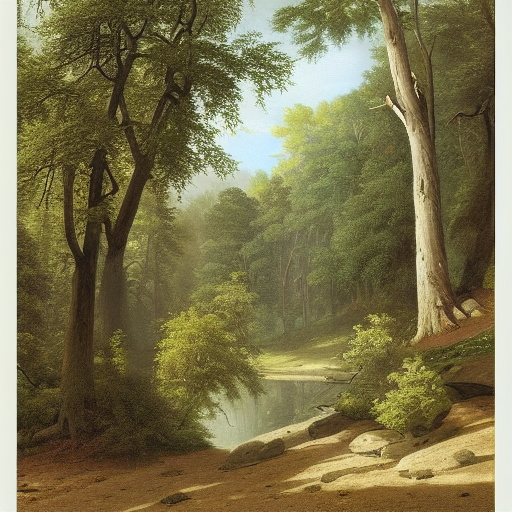

INFO:pytorch_lightning.utilities.seed:Global seed set to 1558795064
100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


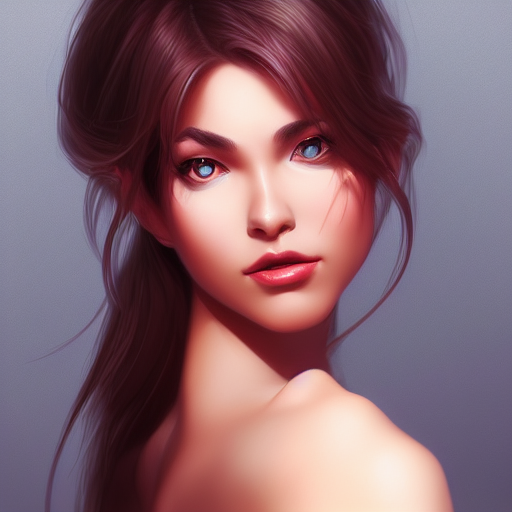

In [11]:
def DeforumArgs():
    #@markdown **Save & Display Settings**
    batch_name = "StableFun" #@param {type:"string"}
    outdir = get_output_folder(output_path, batch_name)
    save_grid = False
    save_settings = True #@param {type:"boolean"}
    save_samples = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}

    #@markdown **Image Settings**
    n_samples = 1 #@param
    W = 512 #@param
    H = 512 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.5 #@param {type:"number"}
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'klms' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim"]
    steps = 10 #@param
    scale = 7 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    seed_behavior = "iter" #@param ["iter","fixed","random"]

    precision = 'autocast' 
    fixed_code = True
    C = 4
    f = 8

    prompt = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_c = None

    return locals()

def next_seed(args):
    if args.seed_behavior == 'iter':
        args.seed += 1
    elif args.seed_behavior == 'fixed':
        pass # always keep seed the same
    else:
        args.seed = random.randint(0, 2**32)
    return args.seed


args = SimpleNamespace(**DeforumArgs())
args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

if args.seed == -1:
    args.seed = random.randint(0, 2**32)
if anim_args.animation_mode == 'Video Input':
    args.use_init = True
if not args.use_init:
    args.init_image = None
    args.strength = 0
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

def render_image_batch(args):
    args.prompts = prompts
    
    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    if args.save_settings or args.save_samples:
        print(f"Saving to {os.path.join(args.outdir, args.timestring)}_*")

    # save settings for the batch
    if args.save_settings:
        filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
        with open(filename, "w+", encoding="utf-8") as f:
            json.dump(dict(args.__dict__), f, ensure_ascii=False, indent=4)

    index = 0
    
    # function for init image batching
    init_array = []
    if args.use_init:
        if args.init_image == "":
            raise FileNotFoundError("No path was given for init_image")
        if args.init_image.startswith('http://') or args.init_image.startswith('https://'):
            init_array.append(args.init_image)
        elif not os.path.isfile(args.init_image):
            if args.init_image[-1] != "/": # avoids path error by adding / to end if not there
                args.init_image += "/" 
            for image in sorted(os.listdir(args.init_image)): # iterates dir and appends images to init_array
                if image.split(".")[-1] in ("png", "jpg", "jpeg"):
                    init_array.append(args.init_image + image)
        else:
            init_array.append(args.init_image)
    else:
        init_array = [""] 

    for batch_index in range(args.n_batch):
        print(f"Batch {batch_index+1} of {args.n_batch}")
        
        for image in init_array: # iterates the init images
            args.init_image = image
            for prompt in prompts:
                args.prompt = prompt
                results = generate(args)
                for image in results:
                    if args.save_samples:
                        filename = f"{args.timestring}_{index:05}_{args.seed}.png"
                        image.save(os.path.join(args.outdir, filename))
                    if args.display_samples:
                        display.display(image)
                    index += 1
                args.seed = next_seed(args)


def render_animation(args, anim_args):
    # animations use key framed prompts
    args.prompts = animation_prompts

    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    print(f"Saving animation frames to {args.outdir}")

    # save settings for the batch
    settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
    with open(settings_filename, "w+", encoding="utf-8") as f:
        s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
        json.dump(s, f, ensure_ascii=False, indent=4)

    # expand prompts out to per-frame
    prompt_series = pd.Series([np.nan for a in range(anim_args.max_frames)])
    for i, prompt in animation_prompts.items():
        prompt_series[i] = prompt
    prompt_series = prompt_series.ffill().bfill()

    # check for video inits
    using_vid_init = anim_args.animation_mode == 'Video Input'

    args.n_samples = 1
    prev_sample = None
    color_match_sample = None
    for frame_idx in range(anim_args.max_frames):
        print(f"Rendering animation frame {frame_idx} of {anim_args.max_frames}")

        # apply transforms to previous frame
        if prev_sample is not None:
            if anim_args.key_frames:
                angle = angle_series[frame_idx]
                zoom = zoom_series[frame_idx]
                translation_x = translation_x_series[frame_idx]
                translation_y = translation_y_series[frame_idx]
                print(
                    f'angle: {angle}',
                    f'zoom: {zoom}',
                    f'translation_x: {translation_x}',
                    f'translation_y: {translation_y}',
                )
            xform = make_xform_2d(args.W, args.H, translation_x, translation_y, angle, zoom)

            # transform previous frame
            prev_img = sample_to_cv2(prev_sample)
            prev_img = cv2.warpPerspective(
                prev_img,
                xform,
                (prev_img.shape[1], prev_img.shape[0]),
                borderMode=cv2.BORDER_WRAP if anim_args.border == 'wrap' else cv2.BORDER_REPLICATE
            )

            # apply color matching
            if anim_args.color_coherence == 'MatchFrame0':
                if color_match_sample is None:
                    color_match_sample = prev_img.copy()
                else:
                    prev_img = maintain_colors(prev_img, color_match_sample, (frame_idx%2) == 0)

            # apply frame noising
            noised_sample = add_noise(sample_from_cv2(prev_img), anim_args.previous_frame_noise)

            # use transformed previous frame as init for current
            args.use_init = True
            args.init_sample = noised_sample.half().to(device)
            args.strength = max(0.0, min(1.0, anim_args.previous_frame_strength))

        # grab prompt for current frame
        args.prompt = prompt_series[frame_idx]
        print(f"{args.prompt} {args.seed}")

        # grab init image for current frame
        if using_vid_init:
            init_frame = os.path.join(args.outdir, 'inputframes', f"{frame_idx+1:04}.jpg")            
            print(f"Using video init frame {init_frame}")
            args.init_image = init_frame

        # sample the diffusion model
        results = generate(args, return_latent=False, return_sample=True)
        sample, image = results[0], results[1]
    
        filename = f"{args.timestring}_{frame_idx:05}.png"
        image.save(os.path.join(args.outdir, filename))
        if not using_vid_init:
            prev_sample = sample
        
        display.clear_output(wait=True)
        display.display(image)

        args.seed = next_seed(args)

def render_input_video(args, anim_args):
    # create a folder for the video input frames to live in
    video_in_frame_path = os.path.join(args.outdir, 'inputframes') 
    os.makedirs(os.path.join(args.outdir, video_in_frame_path), exist_ok=True)
    
    # save the video frames from input video
    print(f"Exporting Video Frames (1 every {anim_args.extract_nth_frame}) frames to {video_in_frame_path}...")
    try:
        for f in pathlib.Path(video_in_frame_path).glob('*.jpg'):
            f.unlink()
    except:
        pass
    vf = f'select=not(mod(n\,{anim_args.extract_nth_frame}))'
    subprocess.run([
        'ffmpeg', '-i', f'{anim_args.video_init_path}', 
        '-vf', f'{vf}', '-vsync', 'vfr', '-q:v', '2', 
        '-loglevel', 'error', '-stats',  
        os.path.join(video_in_frame_path, '%04d.jpg')
    ], stdout=subprocess.PIPE).stdout.decode('utf-8')

    # determine max frames from length of input frames
    anim_args.max_frames = len([f for f in pathlib.Path(video_in_frame_path).glob('*.jpg')])

    args.use_init = True
    print(f"Loading {anim_args.max_frames} input frames from {video_in_frame_path} and saving video frames to {args.outdir}")
    render_animation(args, anim_args)

def render_interpolation(args, anim_args):
    # animations use key framed prompts
    args.prompts = animation_prompts

    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    print(f"Saving animation frames to {args.outdir}")

    # save settings for the batch
    settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
    with open(settings_filename, "w+", encoding="utf-8") as f:
        s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
        json.dump(s, f, ensure_ascii=False, indent=4)
    
    # Interpolation Settings
    args.n_samples = 1
    args.seed_behavior = 'fixed' # force fix seed at the moment bc only 1 seed is available
    prompts_c_s = [] # cache all the text embeddings

    print(f"Preparing for interpolation of the following...")

    for i, prompt in animation_prompts.items():
      args.prompt = prompt

      # sample the diffusion model
      results = generate(args, return_c=True)
      c, image = results[0], results[1]
      prompts_c_s.append(c) 
      
      # display.clear_output(wait=True)
      display.display(image)
      
      args.seed = next_seed(args)

    display.clear_output(wait=True)
    print(f"Interpolation start...")

    frame_idx = 0

    for i in range(len(prompts_c_s)-1):
      for j in range(anim_args.interpolate_x_frames+1):
        # interpolate the text embedding
        prompt1_c = prompts_c_s[i]
        prompt2_c = prompts_c_s[i+1]  
        args.init_c = prompt1_c.add(prompt2_c.sub(prompt1_c).mul(j * 1/(anim_args.interpolate_x_frames+1)))

        # sample the diffusion model
        results = generate(args)
        image = results[0]

        filename = f"{args.timestring}_{frame_idx:05}.png"
        image.save(os.path.join(args.outdir, filename))
        frame_idx += 1

        display.clear_output(wait=True)
        display.display(image)

        args.seed = next_seed(args)

    # generate the last prompt
    args.init_c = prompts_c_s[-1]
    results = generate(args)
    image = results[0]
    filename = f"{args.timestring}_{frame_idx:05}.png"
    image.save(os.path.join(args.outdir, filename))

    display.clear_output(wait=True)
    display.display(image)
    args.seed = next_seed(args)

    #clear init_c
    args.init_c = None

if anim_args.animation_mode == '2D':
    render_animation(args, anim_args)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(args, anim_args)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(args, anim_args)
else:
    render_image_batch(args)    